# Владимир Смолев
## Практика в WebGame
## Предсказание конверта в плательщика по первому дню игры

Задание:
Имея данные за первый день/два игры, необходимо предсказать вероятность того, что игрок станет плательщиком. Бонус: предсказать тип плательщика (после их стандартной классификации на китов, дельфинов, пескарей и пр.)


Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

Загружаю таблички.

In [2]:
practice_dau = pd.read_csv('practice_dau_and.csv', sep='|', names = ['id', 'country','number_of_pgr', 'actdate'])

In [3]:
practice_pact = pd.read_csv('practice_pact_and.csv', sep='|', names = ['id', 'actdate', 'regdate', 'clusters_ml_ended',
                                                                      'revenue', 'transactions', 'quests_end',
                                                                       'm_quests_end', 'crystals_value_spend',
                                                                       'store_enters'])

In [4]:
practice_sessions = pd.read_csv('practice_sessions_and.csv', sep='|', names = ['id', 'session_number','session_length',
                                                                              'session_start_time', 'session_end_time',
                                                                              'actdate'])

## Описание данных.
### 1. practice_dau - ежедневные сообщения с устройства игрока
id - идентификатор игрока;

сountry - страна;

number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры);

actdate - дата события.

### 2. practice_pact - агрегированные данные о деятельности игрока в этот день
id - идентификатор игрока;

actdate - дата события;

regdate - дата регистрации игрока;

clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок;

revenue - прибыль с игрока;

transactions - количество платежей;

quests_end - сколько побочных квестов прошел игрок;

m_quests_end - сколько квестов основной сюжетной линии прошел игрок;

crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок;

store_enters - сколько раз игрок зашел в магазин.

### 3.  practice_sessions - данные о сессиях игрока
id - идентификатор игрока;

session_number - порядковый номер сессии игрока;

session_length - длина сессии;

session_start_time - время начала сессии,

session_end_time - время окончания сессии,

actdate - дата события.

Посмотрим на данные.

In [5]:
print(practice_dau.shape)
practice_dau['actdate'] = pd.to_datetime(practice_dau['actdate'])
practice_dau.head(5)

(8519524, 4)


,id,country,number_of_pgr,actdate
0,c7a56d9eee,FR,33,2017-01-01
1,bd4b8c265d,GB,47,2017-01-20
2,bd4b8c265d,GB,6,2017-01-27
3,bd4b8c265d,GB,11,2017-01-25
4,bd4b8c265d,GB,78,2017-02-05


In [6]:
print(practice_pact.shape)
practice_pact['actdate'] = pd.to_datetime(practice_pact['actdate'])
practice_pact['regdate'] = pd.to_datetime(practice_pact['regdate'])
practice_pact.head(5)

(5919245, 10)


,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,abee37a4e1,2017-01-01,2017-01-01,7,0.0,0,61,13,0,0
1,6fbbafd123,2017-01-01,2017-01-01,5,0.0,0,73,14,0,0
2,23c025efd0,2017-01-01,2017-01-01,7,0.0,0,91,17,0,0
3,8f4b043ead,2017-01-01,2017-01-01,2,0.0,0,14,1,0,0
4,1bdb89a697,2017-01-01,2017-01-01,2,0.0,0,11,0,0,0


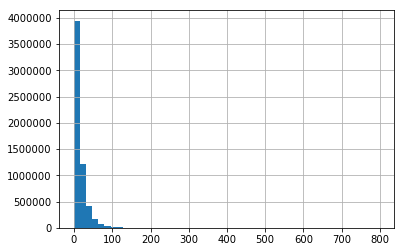

In [8]:
import matplotlib.pyplot as plt
practice_pact.quests_end.hist(bins=50)

In [9]:
print(practice_sessions.shape)
practice_sessions['actdate'] = pd.to_datetime(practice_sessions['actdate'])
practice_sessions['session_start_time'] = pd.to_datetime(practice_sessions['session_start_time'], unit='s') - practice_sessions['actdate']
practice_sessions['session_end_time'] = pd.to_datetime(practice_sessions['session_end_time'], unit='s') - practice_sessions['actdate']
practice_sessions.head(5)

(32533314, 6)


,id,session_number,session_length,session_start_time,session_end_time,actdate
0,14d94a58b7,13.0,57,18:14:49,18:15:46,2017-01-25
1,26620badd1,4.0,132,01:33:40,01:35:52,2017-01-06
2,01d7674aa8,7.0,83,21:34:41,21:36:04,2017-02-09
3,14611edffb,3.0,211,13:22:15,13:25:46,2017-02-06
4,3c13bd2cec,2.0,1206,08:37:45,08:57:51,2017-02-05


Проверим значения в выгруженных таблицах. Есть ли там пропущенные значения.

In [10]:
print('Всего', practice_dau.isnull().sum().sum() )
print(practice_dau.isnull().sum())

Всего 1715
id                  0
country          1715
number_of_pgr       0
actdate             0
dtype: int64


In [11]:
print('Всего', practice_pact.isnull().sum().sum() )
print(practice_pact.isnull().sum())

Всего 0
id                      0
actdate                 0
regdate                 0
clusters_ml_ended       0
revenue                 0
transactions            0
quests_end              0
m_quests_end            0
crystals_value_spend    0
store_enters            0
dtype: int64


In [12]:
print('Всего', practice_sessions.isnull().sum().sum() )
print(practice_sessions.isnull().sum())

Всего 23632945
id                           0
session_number        23632945
session_length               0
session_start_time           0
session_end_time             0
actdate                      0
dtype: int64


In [13]:
23632945/practice_sessions.shape[0]

0.7264229214398509

В двух таблицах есть пропущенные значения. (Спросить что с ними делать)
В таблице по сессиим нет номера сессии в 72%. Но так то это не важно. Можно восстановить по дате если понадобится.

In [14]:
for i in practice_pact.columns[3:]:
    print('%(id)s,min: %(min)s, max %(max)s, mean %(mean)s' %
          {'id': i, 'min': practice_pact[i].min(), 'max':practice_pact[i].max(), 'mean':practice_pact[i].mean() })

clusters_ml_ended,min: -2, max 98, mean 8.330775799954218
revenue,min: 0.0, max 184607.43, mean 108.17581413345603
transactions,min: 0, max 83, mean 0.024564281424404633
quests_end,min: 0, max 796, mean 15.195209524187629
m_quests_end,min: 0, max 141, mean 3.2064535257452595
crystals_value_spend,min: 0, max 0, mean 0.0
store_enters,min: 0, max 0, mean 0.0


Выберем данные с которыми будем работатью. 

Найдем дни активности пользователей совпадающие с регистрацией.

In [15]:
print('Кол-во активности в день регистрации',
      practice_pact[practice_pact['actdate'] == practice_pact['regdate']].shape)
print('Кол-во уникальных id',
      practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].unique().shape)

Кол-во активности в день регистрации (2060626, 10)
Кол-во уникальных id (2016708,)


Получается, что регистрация и активность дня совпадала для некоторых id.

Эти пользователи регистрировались несколько раз.

In [16]:
#Данные о первом дне всех(включая дважды зареганных)
first_day = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]

In [17]:
#Те, кто регестрировался несколько раз, берем первый
first_day = pd.merge(first_day, practice_pact.groupby('id', as_index= False).min()[['id', 'regdate']], on=['id', 'regdate'], how='inner')

In [18]:
first_day = first_day[first_day['revenue'] == 0]
#Те, кто заплатил в первый день не интересны.

In [19]:
print(first_day.shape)
first_day.head()

(2009208, 10)


,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,abee37a4e1,2017-01-01,2017-01-01,7,0.0,0,61,13,0,0
1,6fbbafd123,2017-01-01,2017-01-01,5,0.0,0,73,14,0,0
2,23c025efd0,2017-01-01,2017-01-01,7,0.0,0,91,17,0,0
3,8f4b043ead,2017-01-01,2017-01-01,2,0.0,0,14,1,0,0
4,1bdb89a697,2017-01-01,2017-01-01,2,0.0,0,11,0,0,0


In [21]:
'''Список id для которых есть повторы
Уберу id которые дважды регистрировались
bad_id = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts()[practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts() > 1].index
bad_id
def bad_column(id):
    return int(id in bad_id)
bad_column = practice_pact['id'].apply(bad_column)
practice_pact['bad_column_id'] = bad_column
practice_pact.drop(practice_pact[practice_pact['bad_column_id'] == 1].index, axis = 0, inplace = True)
practice_pact.drop('bad_column_id', axis = 1, inplace = True)
'''

"Список id для которых есть повторы\nbad_id = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts()[practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts() > 1].index\nbad_id\ndef bad_column(id):\n    return int(id in bad_id)\nbad_column = practice_pact['id'].apply(bad_column)\npractice_pact['bad_column_id'] = bad_column\npractice_pact.drop(practice_pact[practice_pact['bad_column_id'] == 1].index, axis = 0, inplace = True)\npractice_pact.drop('bad_column_id', axis = 1, inplace = True)\n"

In [20]:
revenue_positive_id = practice_pact.groupby('id').sum()[practice_pact.groupby('id').sum()['revenue'] > 0].index
#Там, где будет единица в целевой переменной

In [19]:
new_data_fd = pd.merge(first_day, practice_sessions, on=['id', 'actdate'], how='inner')
#добавлю данные о сессиях в первый день

In [20]:
amount_visits_fd = pd.DataFrame(data = np.array([new_data_fd['id'].value_counts().index, new_data_fd['id'].value_counts().values]).T, columns=['id', 'amount_visits'])
#Количетсво посещений в первый день

In [21]:
first_day = pd.merge(first_day, amount_visits_fd, on=['id'], how='inner')
first_day = pd.merge(first_day, new_data_fd.groupby('id', as_index = False).sum()[['id', 'session_length']], on=['id'], how='inner')
first_day = pd.merge(first_day, new_data_fd.groupby('id', as_index = False).min()[['id', 'session_start_time','session_end_time']], on=['id'], how='inner')
#добавим к данным количество посещений,длину всех посещений в первый день и информацию о самом первом заходе

In [22]:
first_day.drop(['store_enters', 'revenue', 'regdate', 'transactions', 'crystals_value_spend'], axis = 1, inplace = True)
#они вроде нулевые => уберем

In [23]:
first_day['average_visit'] = first_day['session_length']/first_day['amount_visits']

In [24]:
first_day.head()

,id,actdate,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,session_start_time,session_end_time,average_visit
0,abee37a4e1,2017-01-01,7,61,13,6,5873,08:57:58,09:28:24,978.833
1,6fbbafd123,2017-01-01,5,73,14,6,7735,17:21:00,17:51:47,1289.17
2,23c025efd0,2017-01-01,7,91,17,4,6907,10:53:15,11:33:07,1726.75
3,8f4b043ead,2017-01-01,2,14,1,1,1424,21:50:46,22:14:30,1424
4,1bdb89a697,2017-01-01,2,11,0,1,521,02:52:00,03:00:41,521


Разберемся с первой таблицей. Добавим данные по стране и колчиству сообщений от устройства.

In [25]:
#у некоторых пользователей нет страны, заполним пропуск
practice_dau.fillna(value='NAN', inplace = True)

In [1]:
# 1 - америка, 2 - Азия, 3 - Европа, 4 - африка, 5 - австралия, 6-южная америка;10 - остальные;
country_dict = {'--': 0, 'A1': 0, 'A2': 0, 'AD': 0, 'AE': 2, 'AF': 0, 'AG': 0, 'AI': 0, 'AL': 3, 'AM': 3, 'AO': 0, 'AP': 0, 'AQ': 0, 'AR': 6, 'AS': 0, 'AT': 3, 'AU': 5, 'AW': 0, 'AX': 0, 'AZ': 2, 'BA': 3, 'BB': 0, 'BD': 2, 'BE': 3, 'BF': 0, 'BG': 3, 'BH': 3, 'BJ': 0, 'BM': 0, 'BN': 2, 'BO': 4, 'BQ': 0, 'BR': 6, 'BS': 0, 'BT': 0, 'BW': 0, 'BY': 3, 'BZ': 0, 'CA': 1, 'CD': 0, 'CG': 0, 'CH': 3, 'CI': 4, 'CL': 6, 'CM': 4, 'CN': 2, 'CO': 6, 'CR': 6, 'CU': 0, 'CV': 0, 'CW': 0, 'CY': 3, 'CZ': 3, 'DE': 3, 'DJ': 0, 'DK': 3, 'DM': 0, 'DO': 6, 'DZ': 4, 'EC': 6, 'EE': 3, 'EG': 4, 'ES': 3, 'ET': 0, 'EU': 0, 'FI': 3, 'FJ': 5, 'FM': 0, 'FO': 0, 'FR': 3, 'GA': 0, 'GB': 3, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 4, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GP': 0, 'GQ': 0, 'GR': 3, 'GT': 6, 'GU': 0, 'GW': 0, 'GY': 0, 'HK': 2, 'HN': 6, 'HR': 3, 'HT': 6, 'HU': 3, 'ID': 2, 'IE': 3, 'IL': 2, 'IM': 0, 'IN': 2, 'IQ': 2, 'IR': 2, 'IS': 3, 'IT': 3, 'JE': 0, 'JM': 6, 'JO': 2, 'JP': 2, 'KE': 4, 'KG': 2, 'KH': 2, 'KN': 0, 'KP': 0, 'KR': 2, 'KW': 2, 'KY': 0, 'KZ': 2, 'LA': 2, 'LB': 2, 'LC': 0, 'LI': 0, 'LK': 2, 'LR': 0, 'LS': 0, 'LT': 3, 'LU': 3, 'LV': 3, 'LY': 0, 'MA': 4, 'MC': 0, 'MD': 3, 'ME': 0, 'MF': 0, 'MG': 0, 'MH': 0, 'MK': 3, 'ML': 0, 'MM': 0, 'MN': 0, 'MO': 0, 'MP': 0, 'MQ': 0, 'MR': 0, 'MT': 3, 'MU': 4, 'MV': 0, 'MX': 6, 'MY': 2, 'MZ': 4, 'NAN': 0, 'NC': 0, 'NE': 0, 'NG': 4, 'NI': 6, 'NL': 3, 'NO': 3, 'NP': 2, 'NR': 0, 'NZ': 6, 'OM': 2, 'PA': 6, 'PE': 6, 'PF': 0, 'PG': 0, 'PH': 2, 'PK': 2, 'PL': 3, 'PM': 0, 'PR': 6, 'PS': 0, 'PT': 3, 'PW': 0, 'PY': 6, 'QA': 2, 'RE': 0, 'RO': 3, 'RS': 3, 'RU': 3, 'RW': 0, 'SA': 2, 'SC': 0, 'SD': 0, 'SE': 3, 'SG': 2, 'SI': 3, 'SK': 3, 'SL': 0, 'SM': 0, 'SN': 4, 'SO': 0, 'SR': 0, 'SS': 0, 'ST': 0, 'SV': 6, 'SX': 0, 'SY': 2, 'SZ': 0, 'TG': 0, 'TH': 2, 'TJ': 0, 'TL': 0, 'TM': 2, 'TN': 4, 'TO': 0, 'TR': 2, 'TT': 6, 'TW': 2, 'TZ': 4, 'UA': 3, 'UG': 0, 'US': 1, 'UY': 6, 'UZ': 2, 'VC': 0, 'VE': 6, 'VG': 0, 'VI': 0, 'VN': 2, 'VU': 0, 'WS': 0, 'YE': 2, 'YT': 0, 'ZA': 4, 'ZM': 0, 'ZW': 0}

In [76]:
#first_day = pd.merge(first_day, practice_dau.groupby(['id', 'actdate'], as_index = False).sum(), on=['id', 'actdate'], how='inner')
#Добавим number_of_pgr в первый день

In [27]:
first_day = pd.merge(first_day, practice_dau.sort_values('number_of_pgr', ascending = 0).groupby(['id', 'actdate'], as_index = False).first(), on=['id', 'actdate'], how='inner')
#Добавим страну и number_of_pgr

In [28]:
def country_to_id(country):
    return country_dict[country]

first_day['country_id'] = first_day['country'].apply(country_to_id)
first_day.drop('country', axis = 1, inplace = True)
#Отсортируем страны по континентам

In [36]:
first_day.head()

,id,actdate,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,average_visit,number_of_pgr,country_id,first_session_start,first_session_end
0,abee37a4e1,2017-01-01,7,61,13,6,5873,978.833333,204,2,32278.0,34104.0
1,6fbbafd123,2017-01-01,5,73,14,6,7735,1289.166667,141,1,62460.0,64307.0
2,23c025efd0,2017-01-01,7,91,17,4,6907,1726.750000,233,3,39195.0,41587.0
3,8f4b043ead,2017-01-01,2,14,1,1,1424,1424.000000,47,3,78646.0,80070.0
4,1bdb89a697,2017-01-01,2,11,0,1,521,521.000000,19,2,10320.0,10841.0


In [30]:
first_day['amount_visits'] = first_day['amount_visits'].astype('int64')
first_day['average_visit'] = first_day['average_visit'].astype('float64')

In [31]:
def to_seconds(session_start_time):
    return session_start_time.total_seconds()
first_day['first_session_start'] = first_day['session_start_time'].apply(to_seconds)
first_day['first_session_end'] = first_day['session_end_time'].apply(to_seconds)

In [32]:
first_day.drop('session_start_time', axis = 1, inplace = True)
first_day.drop('session_end_time', axis = 1, inplace = True)

In [51]:
first_day.dtypes

clusters_ml_ended        int64
quests_end               int64
m_quests_end             int64
amount_visits            int64
session_length           int64
average_visit          float64
number_of_pgr            int64
first_session_start    float64
first_session_end      float64
country_id_0           float64
country_id_1           float64
country_id_2           float64
country_id_3           float64
country_id_4           float64
country_id_5           float64
country_id_6           float64
answer                   int64
dtype: object

Закодируем категориальный признак country_id

In [45]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
new_ohe_features = ohe.fit_transform(first_day.country_id.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['country_id_' + str(i) for i in range(new_ohe_features.shape[1])])
first_day = pd.concat([first_day, tmp], axis = 1)

In [47]:
first_day.drop('country_id', axis = 1, inplace=True)

In [48]:
def cr_answer(id):
    return int(id in revenue_positive_id)

answer = first_day['id'].apply(cr_answer)
first_day['answer'] = answer

In [49]:
first_day.drop(['id', 'actdate'], axis = 1, inplace = True)

In [52]:
first_day['country_id_0'] = first_day['country_id_0'].astype('int64')
first_day['country_id_1'] = first_day['country_id_1'].astype('int64')
first_day['country_id_2'] = first_day['country_id_2'].astype('int64')
first_day['country_id_3'] = first_day['country_id_3'].astype('int64')
first_day['country_id_4'] = first_day['country_id_4'].astype('int64')
first_day['country_id_5'] = first_day['country_id_5'].astype('int64')
first_day['country_id_6'] = first_day['country_id_6'].astype('int64')
first_day['first_session_start'] = first_day['first_session_start'].astype('int64')
first_day['first_session_end'] = first_day['first_session_end'].astype('int64')

In [53]:
first_day.to_csv('first_day1.csv')

## Обучение

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier

In [4]:
first_day = pd.read_csv('first_day1.csv')
first_day.drop('Unnamed: 0', axis = 1, inplace = True) 

In [5]:
pay_persent = first_day[first_day['answer'] > 0].shape[0]/first_day.shape[0]
print('В выборке', round(pay_persent, 2), 'часть платильщиков.')

В выборке 0.01 часть платильщиков.


Что очень мало.

In [6]:
answer = first_day['answer']
first_day.drop('answer', axis = 1, inplace = True)

In [7]:
first_day.head()

,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,average_visit,number_of_pgr,first_session_start,first_session_end,country_id_0,country_id_1,country_id_2,country_id_3,country_id_4,country_id_5,country_id_6
0,7,61,13,6,5873,978.833333,204,32278,34104,0,0,1,0,0,0,0
1,5,73,14,6,7735,1289.166667,141,62460,64307,0,1,0,0,0,0,0
2,7,91,17,4,6907,1726.750000,233,39195,41587,0,0,0,1,0,0,0
3,2,14,1,1,1424,1424.000000,47,78646,80070,0,0,0,1,0,0,0
4,2,11,0,1,521,521.000000,19,10320,10841,0,0,1,0,0,0,0


In [41]:
#Нормализую признаки
normalizer = preprocessing.StandardScaler()
data_real_norm_np = normalizer.fit_transform(first_day)
data_real_norm_pd = pd.DataFrame(data=data_real_norm_np)

In [101]:
#обучим
X_train, X_test, y_train, y_test = train_test_split(data_real_norm_pd, answer, test_size = 0.3, random_state = 42)

## LogisticRegression 

In [102]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1]))
print('Логистическая регрессия, нормализованные данные.')
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, LogReg.predict(X_test)).ravel()
print('Класс платильщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2*tp/(tp+ fp)*tp/(tp +fn)/(tp/(tp+ fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

Логистическая регрессия, нормализованные данные.
Класс платильщиков: Precision =  0.0294 Recall =  0.0001 Fмера =  0.0003
Класс бесплатных:   Precision =  0.9887 Recall =  0.9999 Fмера =  0.9943
TP =  1 	 FP =  33
FN = 6728 	 TN =  587477


Классификатору не выгодно относить к классу платильщиков, потому что их очень мало. И почти все отнесены к другому классу. Поменяем веса в классификаторе. 

In [93]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1]))
print('Логистическая регрессия, нормализованные данные.')
LogReg = LogisticRegression(class_weight = 'balanced')
LogReg.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, LogReg.predict(X_test)).ravel()
print('Класс платильщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2*tp/(tp+ fp)*tp/(tp +fn)/(tp/(tp+ fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

Логистическая регрессия, нормализованные данные.
Класс платильщиков: Precision =  0.0437 Recall =  0.825 Fмера =  0.083
Класс бесплатных:   Precision =  0.9974 Recall =  0.7912 Fмера =  0.8824
TP =  4672 	 FP =  102205
FN = 991 	 TN =  387331


Уже лучше. В каком-то смысле. Попробуем что-нибудь еще.

In [81]:
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True, class_weight = 'balanced')
lr_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.05, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [82]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, lr_sgd.predict_proba(X_test)[:, 1]))
print('SGDClassifier, нормализованные данные.')
tn, fp, fn, tp = metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).ravel()
print('Класс платильщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2 * tp/(tp + fp) * tp / (tp + fn)/(tp / (tp + fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

SGDClassifier, нормализованные данные.
Класс платильщиков: Precision =  0.044 Recall =  0.8199 Fмера =  0.0836
Класс бесплатных:   Precision =  0.9974 Recall =  0.7961 Fмера =  0.8855
TP =  5517 	 FP =  119785
FN = 1212 	 TN =  467725


In [8]:
#обучим на начальной начальной выборке
X_train, X_test, y_train, y_test = train_test_split(first_day, answer, test_size = 0.25, random_state = 42)

Так как одного класса существенно меньше чем другого, проверим ровно ли доля ответов в тестовой и тренировочной выборке.

In [9]:
print('Тренировочная:', y_train[y_train == 0].shape[0]/y_train.shape[0])
print('Тестовая:', y_test[y_test == 0].shape[0]/y_test.shape[0])

Тренировочная: 0.9887681517935214
Тестовая: 0.9885641933848817


С разбиением по классам все хорошо.
Объектов положительного класса очень мало, попробуем сбалансированный веса.

In [86]:
print('Логистическая регрессия, обычные данные.')
LogReg = LogisticRegression(class_weight = 'balanced')
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные.
             precision    recall  f1-score   support

Не заплатит       1.00      0.79      0.88    489536
   Заплатит       0.04      0.83      0.08      5663

avg / total       0.99      0.79      0.87    495199

[[387331    991]
 [102205   4672]]


In [32]:
print('Логистическая регрессия, обычные данные.')
LogReg = LogisticRegression(class_weight = {0:0.03, 1: 1})
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.90      0.95    489536
   Заплатит       0.07      0.60      0.12      5663

avg / total       0.98      0.90      0.94    495199

[[442722   2239]
 [ 46814   3424]]


Подберем вес классов.

In [89]:
params = {
    'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}, 'balanced'],
}

LogRegGrid = GridSearchCV(LogisticRegression(), params, scoring='f1_macro', verbose =True)
LogRegGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0: 0.05, 1: 1}, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=True)

In [91]:
LogRegGrid.best_params_ #лучший вес

{'class_weight': {0: 0.1, 1: 1}}

In [92]:
print('Логистическая регрессия, обычные данные. Вес 0:0.1, 1: 1.')
LogReg = LogisticRegression(class_weight = {0: 0.1, 1: 1})
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные. Вес 0:0.1, 1: 1.
             precision    recall  f1-score   support

Не заплатит       0.99      0.98      0.98    489536
   Заплатит       0.10      0.22      0.14      5663

avg / total       0.98      0.97      0.97    495199

[[478869   4426]
 [ 10667   1237]]


### Пока лучший результат.
По данному предсказанию каждый 10 отмеченный платильщик будет верно определен. И всего должно быть отмечено 22% платильшиков. (вроде деревьями потом будет лучше)

### SGDClassifier.

In [16]:
print('SGDClassifier, обычные данные.')
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True)
lr_sgd.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).ravel()
print(metrics.classification_report(y_test, lr_sgd.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).T)

SGDClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      1.00      0.99    587510
   Заплатит       0.04      0.00      0.01      6729

avg / total       0.98      0.99      0.98    594239

[[587019   6707]
 [   491     22]]


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

## DecisionTreeClassifier
Попробум использовать деревья. Сразу вес поставим сбалансированный.

In [106]:
DTC = DecisionTreeClassifier(class_weight = 'balanced')
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.99      0.99    489536
   Заплатит       0.06      0.05      0.06      5663

avg / total       0.98      0.98      0.98    495199

[[484666   5359]
 [  4870    304]]


Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину, максимальное используемое на каждом разбиении число признаков и вес классов.

In [132]:
tree_params = {'max_depth': range(1,11), 'max_features': range(4,11), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}, 'balanced']}

In [135]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, scoring='f1_micro', verbose = True)

In [136]:
tree_grid.fit(X_train, y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=1)]: Done 1050 out of 1050 | elapsed: 106.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 11), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0: 0.05, 1: 1}, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_micro', verbose=True)

In [137]:
tree_grid.best_params_

{'class_weight': {0: 0.5, 1: 1}, 'max_depth': 1, 'max_features': 4}

In [13]:
DTC = DecisionTreeClassifier(max_depth = 1, max_features = 4, class_weight = {0: 0.5, 1: 1})
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

Не заплатит       0.99      1.00      0.99    489536
   Заплатит       0.00      0.00      0.00      5663

avg / total       0.98      0.99      0.98    495199

[[489536   5663]
 [     0      0]]


Стало хуже. Все отнеслось к одному классу. Потому что параметры настраивались по F1-микро. Попробуем F1-макро. Это среднее от F мер.

In [14]:
tree_params2 = {'max_depth': range(2,9), 'max_features': range(4,9), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, 'balanced']}

In [15]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params2, scoring='f1_macro', verbose = True)
tree_grid.fit(X_train, y_train)

In [17]:
tree_grid.best_params_ #лучшие параметры

{'class_weight': {0: 0.1, 1: 1}, 'max_depth': 8, 'max_features': 6}

In [20]:
DTC = DecisionTreeClassifier(max_depth = 8, max_features = 6, class_weight = {0: 0.1, 1: 1})
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.98      0.98    489536
   Заплатит       0.11      0.22      0.15      5663

avg / total       0.98      0.97      0.98    495199

[[479242   4395]
 [ 10294   1268]]


Результат очень похож на линейный классификатор, но чуть-чуть лучше.

In [30]:
print('Вероятность случайно выбрать платильщика', y_test[y_test == 1].shape[0]/y_test.shape[0])
print('Если предсказано, что не заплатит, то вероятность платильщика', 4395/(479242+4395))
print('Если предсказано, что заплатит, то вероятность платильщика', 1268/(10294+1268))

Вероятность случайно выбрать платильщика 0.011435806615118366
Если предсказано, что не заплатит, то вероятность платильщика 0.00908739405794015
Если предсказано, что заплатит, то вероятность платильщика 0.10966960733437121


In [22]:
for name, importance in zip(first_day.columns, DTC.feature_importances_):
    print(name, importance)

clusters_ml_ended 0.0185462842568
quests_end 0.532020200387
m_quests_end 0.0151493125587
amount_visits 0.004754210924
session_length 0.017661149693
average_visit 0.00818629116323
number_of_pgr 0.0431335491842
first_session_start 0.0483941650371
first_session_end 0.0171107146099
country_id_0 0.0
country_id_1 0.221742527963
country_id_2 0.0361932828017
country_id_3 0.0241206212164
country_id_4 0.00364452083475
country_id_5 0.0061506010801
country_id_6 0.00319256828989


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
print(metrics.classification_report(y_test, GBC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, GBC.predict(X_test)).T)

             precision    recall  f1-score   support

Не заплатит       0.99      1.00      0.99    587510
   Заплатит       0.18      0.00      0.00      6729

avg / total       0.98      0.99      0.98    594239

[[587501   6727]
 [     9      2]]


In [13]:
for name, importance in zip(first_day.columns, GBC.feature_importances_):
    print(name, importance)

clusters_ml_ended 0.0729183285362
quests_end 0.152841964259
m_quests_end 0.0697317826953
amount_visits 0.0750753296404
session_length 0.149164694322
average_visit 0.0633944776253
number_of_pgr 0.0714957669596
first_session_start 0.0921246171028
first_session_end 0.103126880495
country_id_0 0.0
country_id_1 0.0467701770801
country_id_2 0.0374242398058
country_id_3 0.0268062859851
country_id_4 0.00569220386276
country_id_5 0.0312818397184
country_id_6 0.00215141191142
